# Hyper Parameter Optimization for Ridge

In [1]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
MODEL_NAME = 'Ridge'

In [2]:
current_path = os.getcwd()
current_path

'/output/workspace/Band-gap-predict/SingleModels/Ridge'

In [3]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [4]:
from sklearn.base import clone
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline  

## Load Data

In [5]:
# Load data
file_dir = os.path.join(current_path, '../../Data/composition_data/feature_data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'dft', 'train.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'dft', 'test.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'exp', 'train.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'exp', 'test.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

## Model Train

### DFT Model

In [6]:
# using grid search to find the best hyperparameters for the dft model
print(f"['DFT {MODEL_NAME}'] HP optimazation begin...")
# create a pipeline with standard scaler and ElasticNet
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=RANDOM_SEED))
])
# define the parameter grid for ElasticNet
param_grid = {
    'ridge__alpha': np.arange(0, 1.05, 0.05)
}

# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=ridge_pipe, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=kf, 
    n_jobs=-1, 
    verbose=True,
    return_train_score=True)

# fit the model to the training data
grid_search.fit(dft_train_X, dft_train_y)

['DFT Ridge'] HP optimazation begin...
Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge(random_state=42))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=True)

In [7]:
# get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(grid_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_ridge__alpha', 
                                 'train_rmse', 'test_rmse']]

# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
results_sorted.to_csv(os.path.join(hp_path, 'dft_hp_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'ridge__alpha': np.float64(1.0)}
Best Cross-Validation RMSE: 1.1284


,rank_test_score,param_ridge__alpha,train_rmse,test_rmse
20,1,1.00,1.125731,1.128364
19,2,0.95,1.125731,1.128365
18,3,0.90,1.125731,1.128365
17,4,0.85,1.125731,1.128365
16,5,0.80,1.125731,1.128365


### Overfitting check

####################################################################################################
[DFT - Ridge] Training Ridge on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
Model training completed!
[Train_error] Evaluating DFT Ridge on DFT train set:


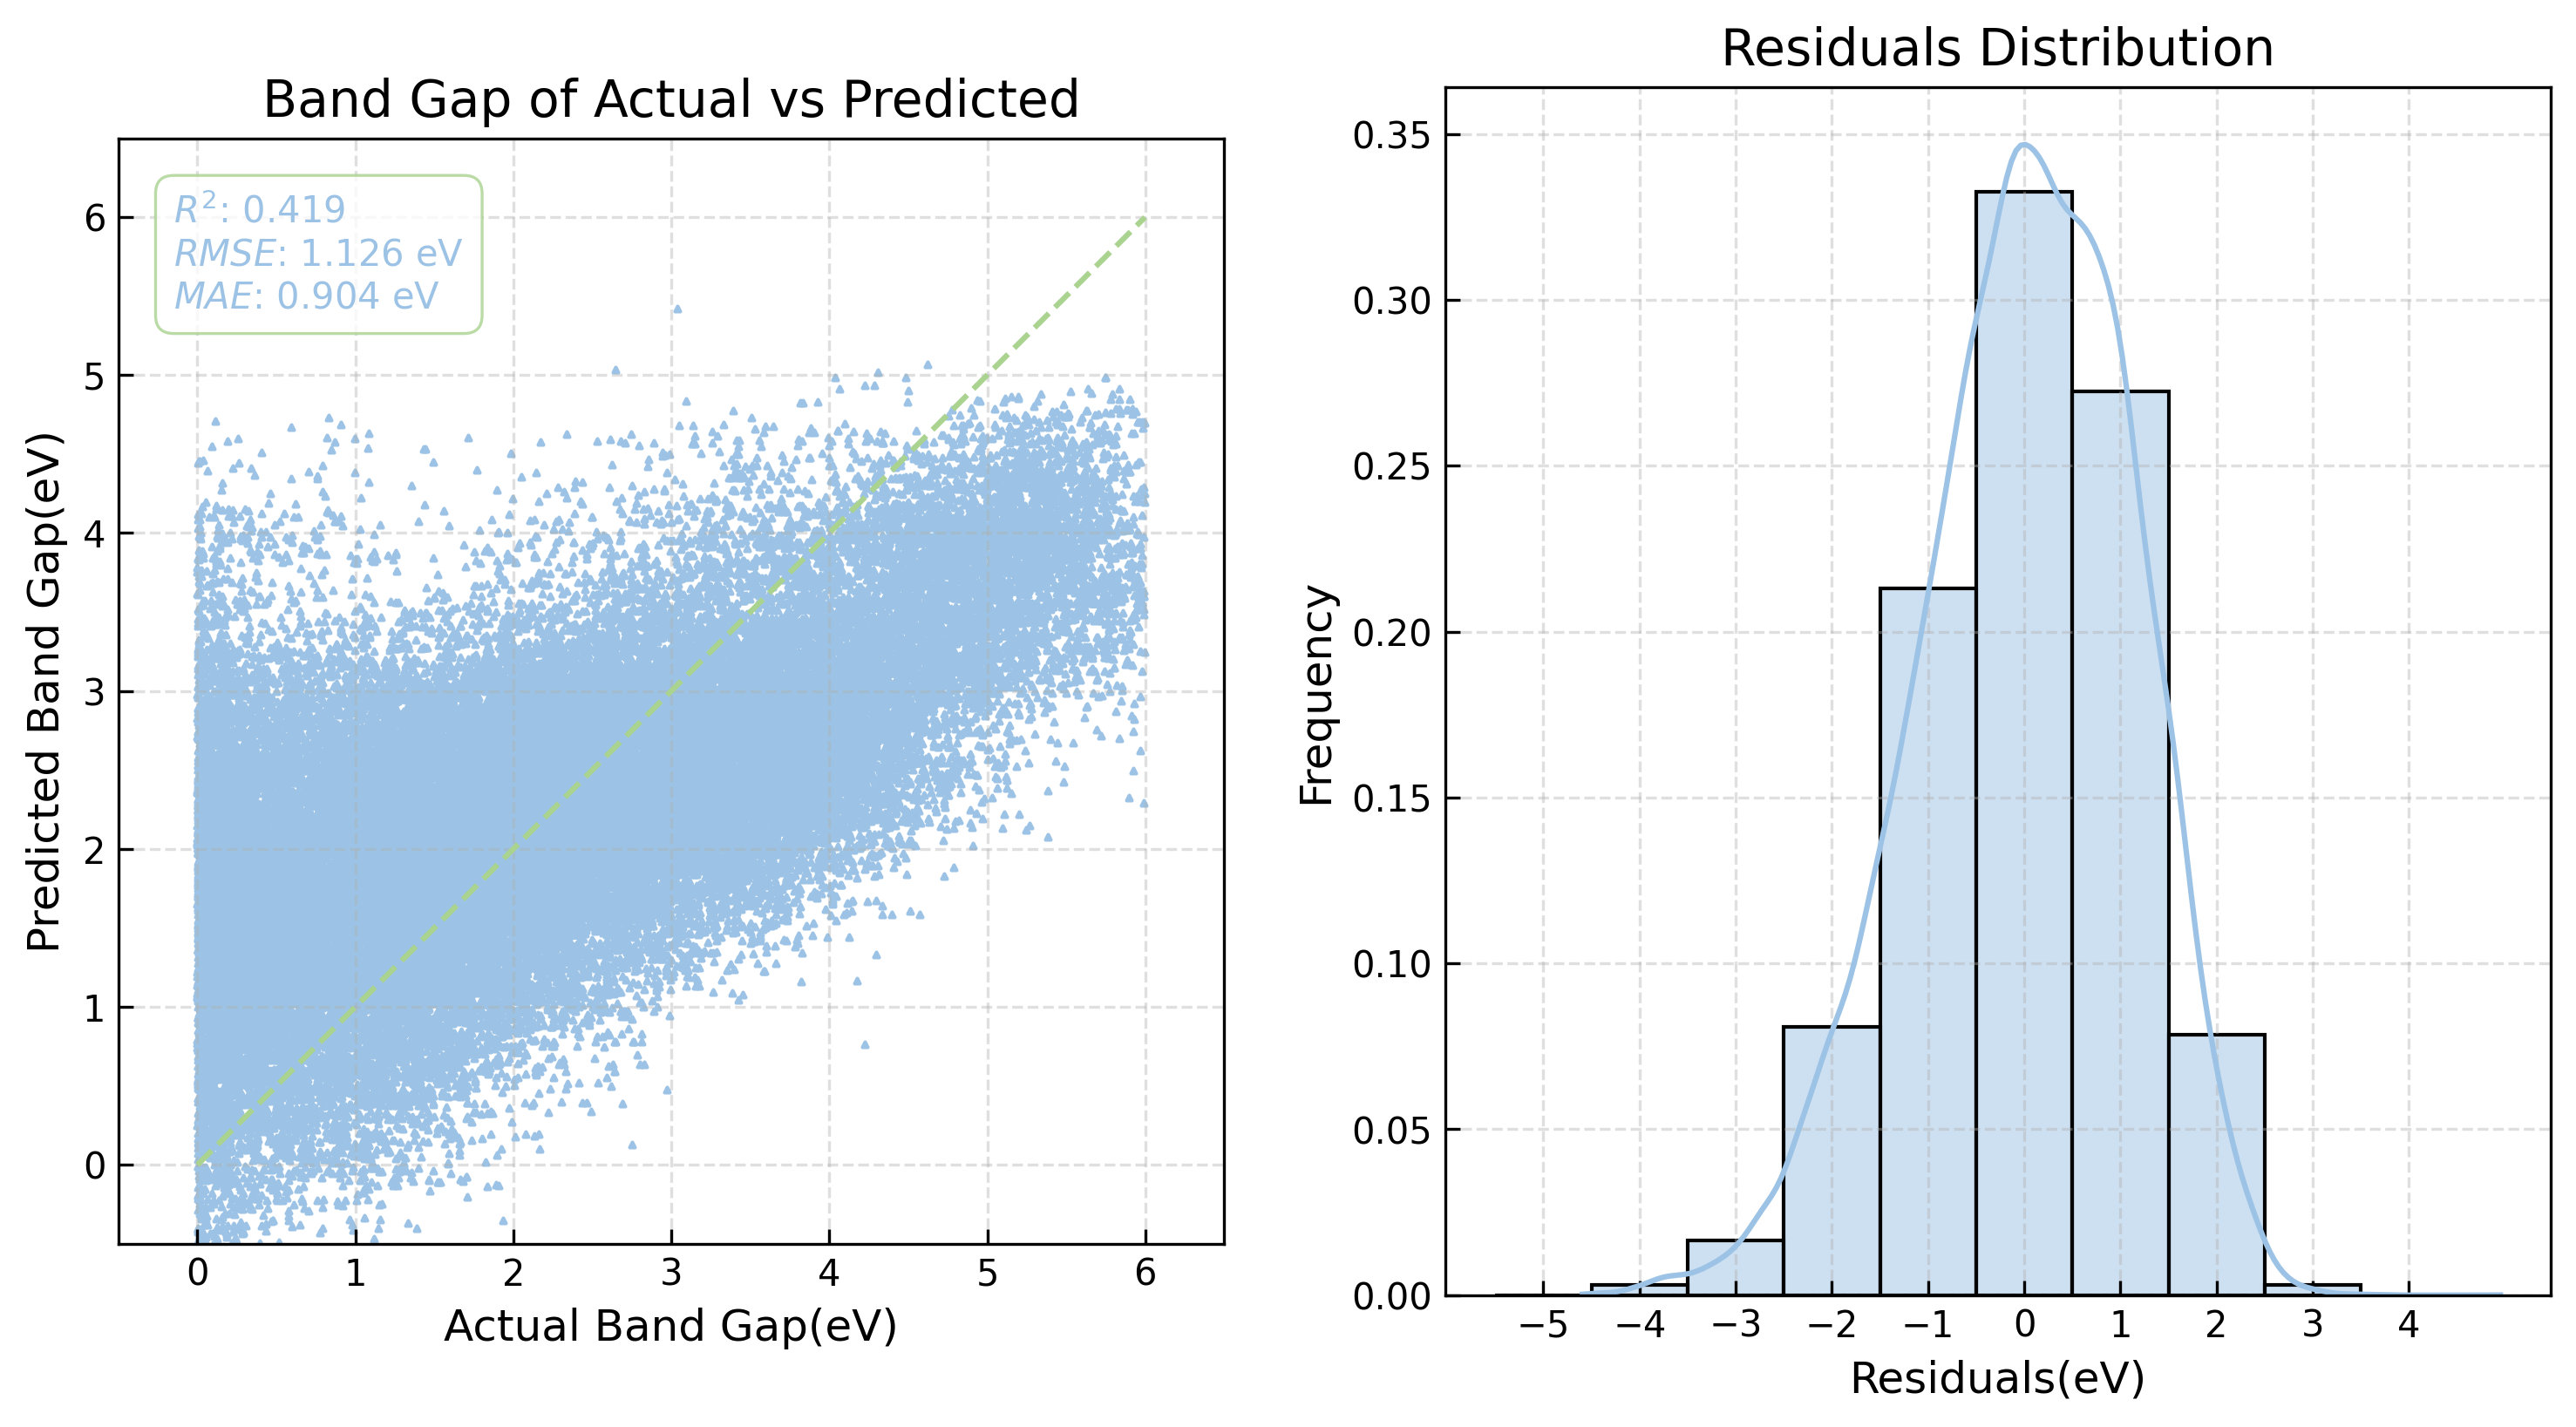


Model Evaluation Results:
Test set: R²: 0.4185 RMSE: 1.1260 MAE: 0.9036
[Test DFT -> DFT] Evaluating DFT Ridge on DFT test set:


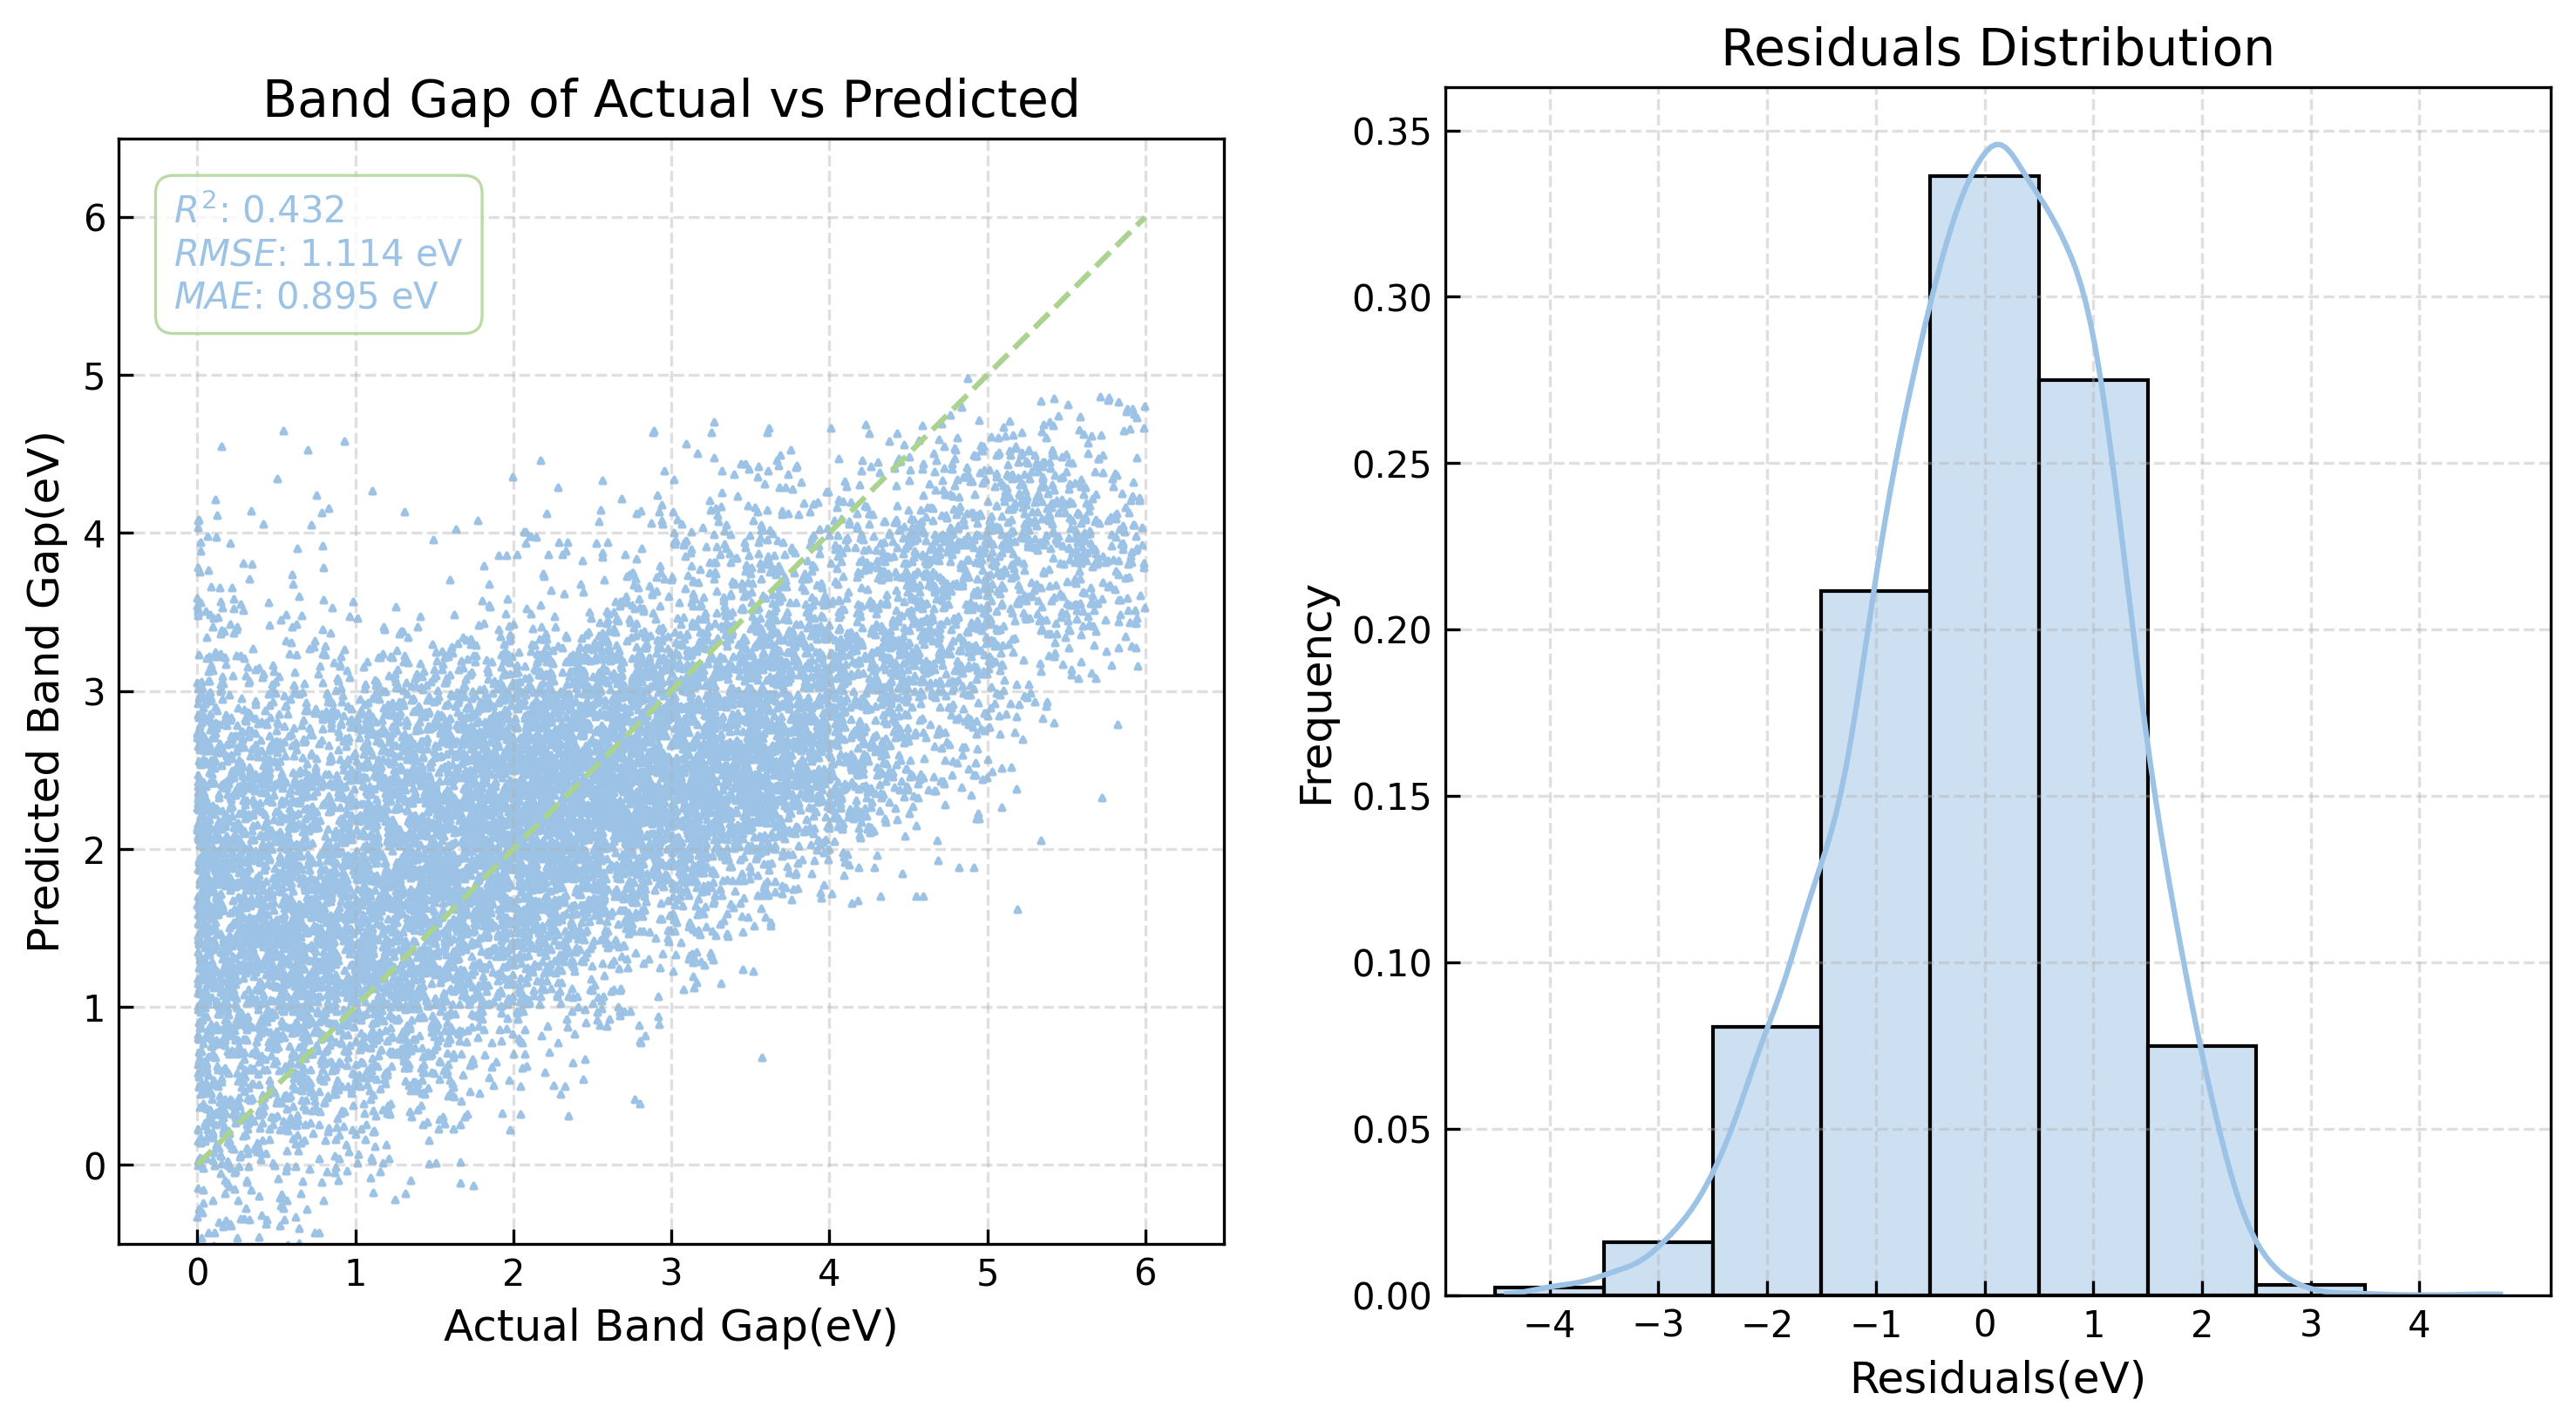


Model Evaluation Results:
Test set: R²: 0.4318 RMSE: 1.1142 MAE: 0.8947
[Test DFT -> EXP] Evaluating DFT Ridge on EXP test set:


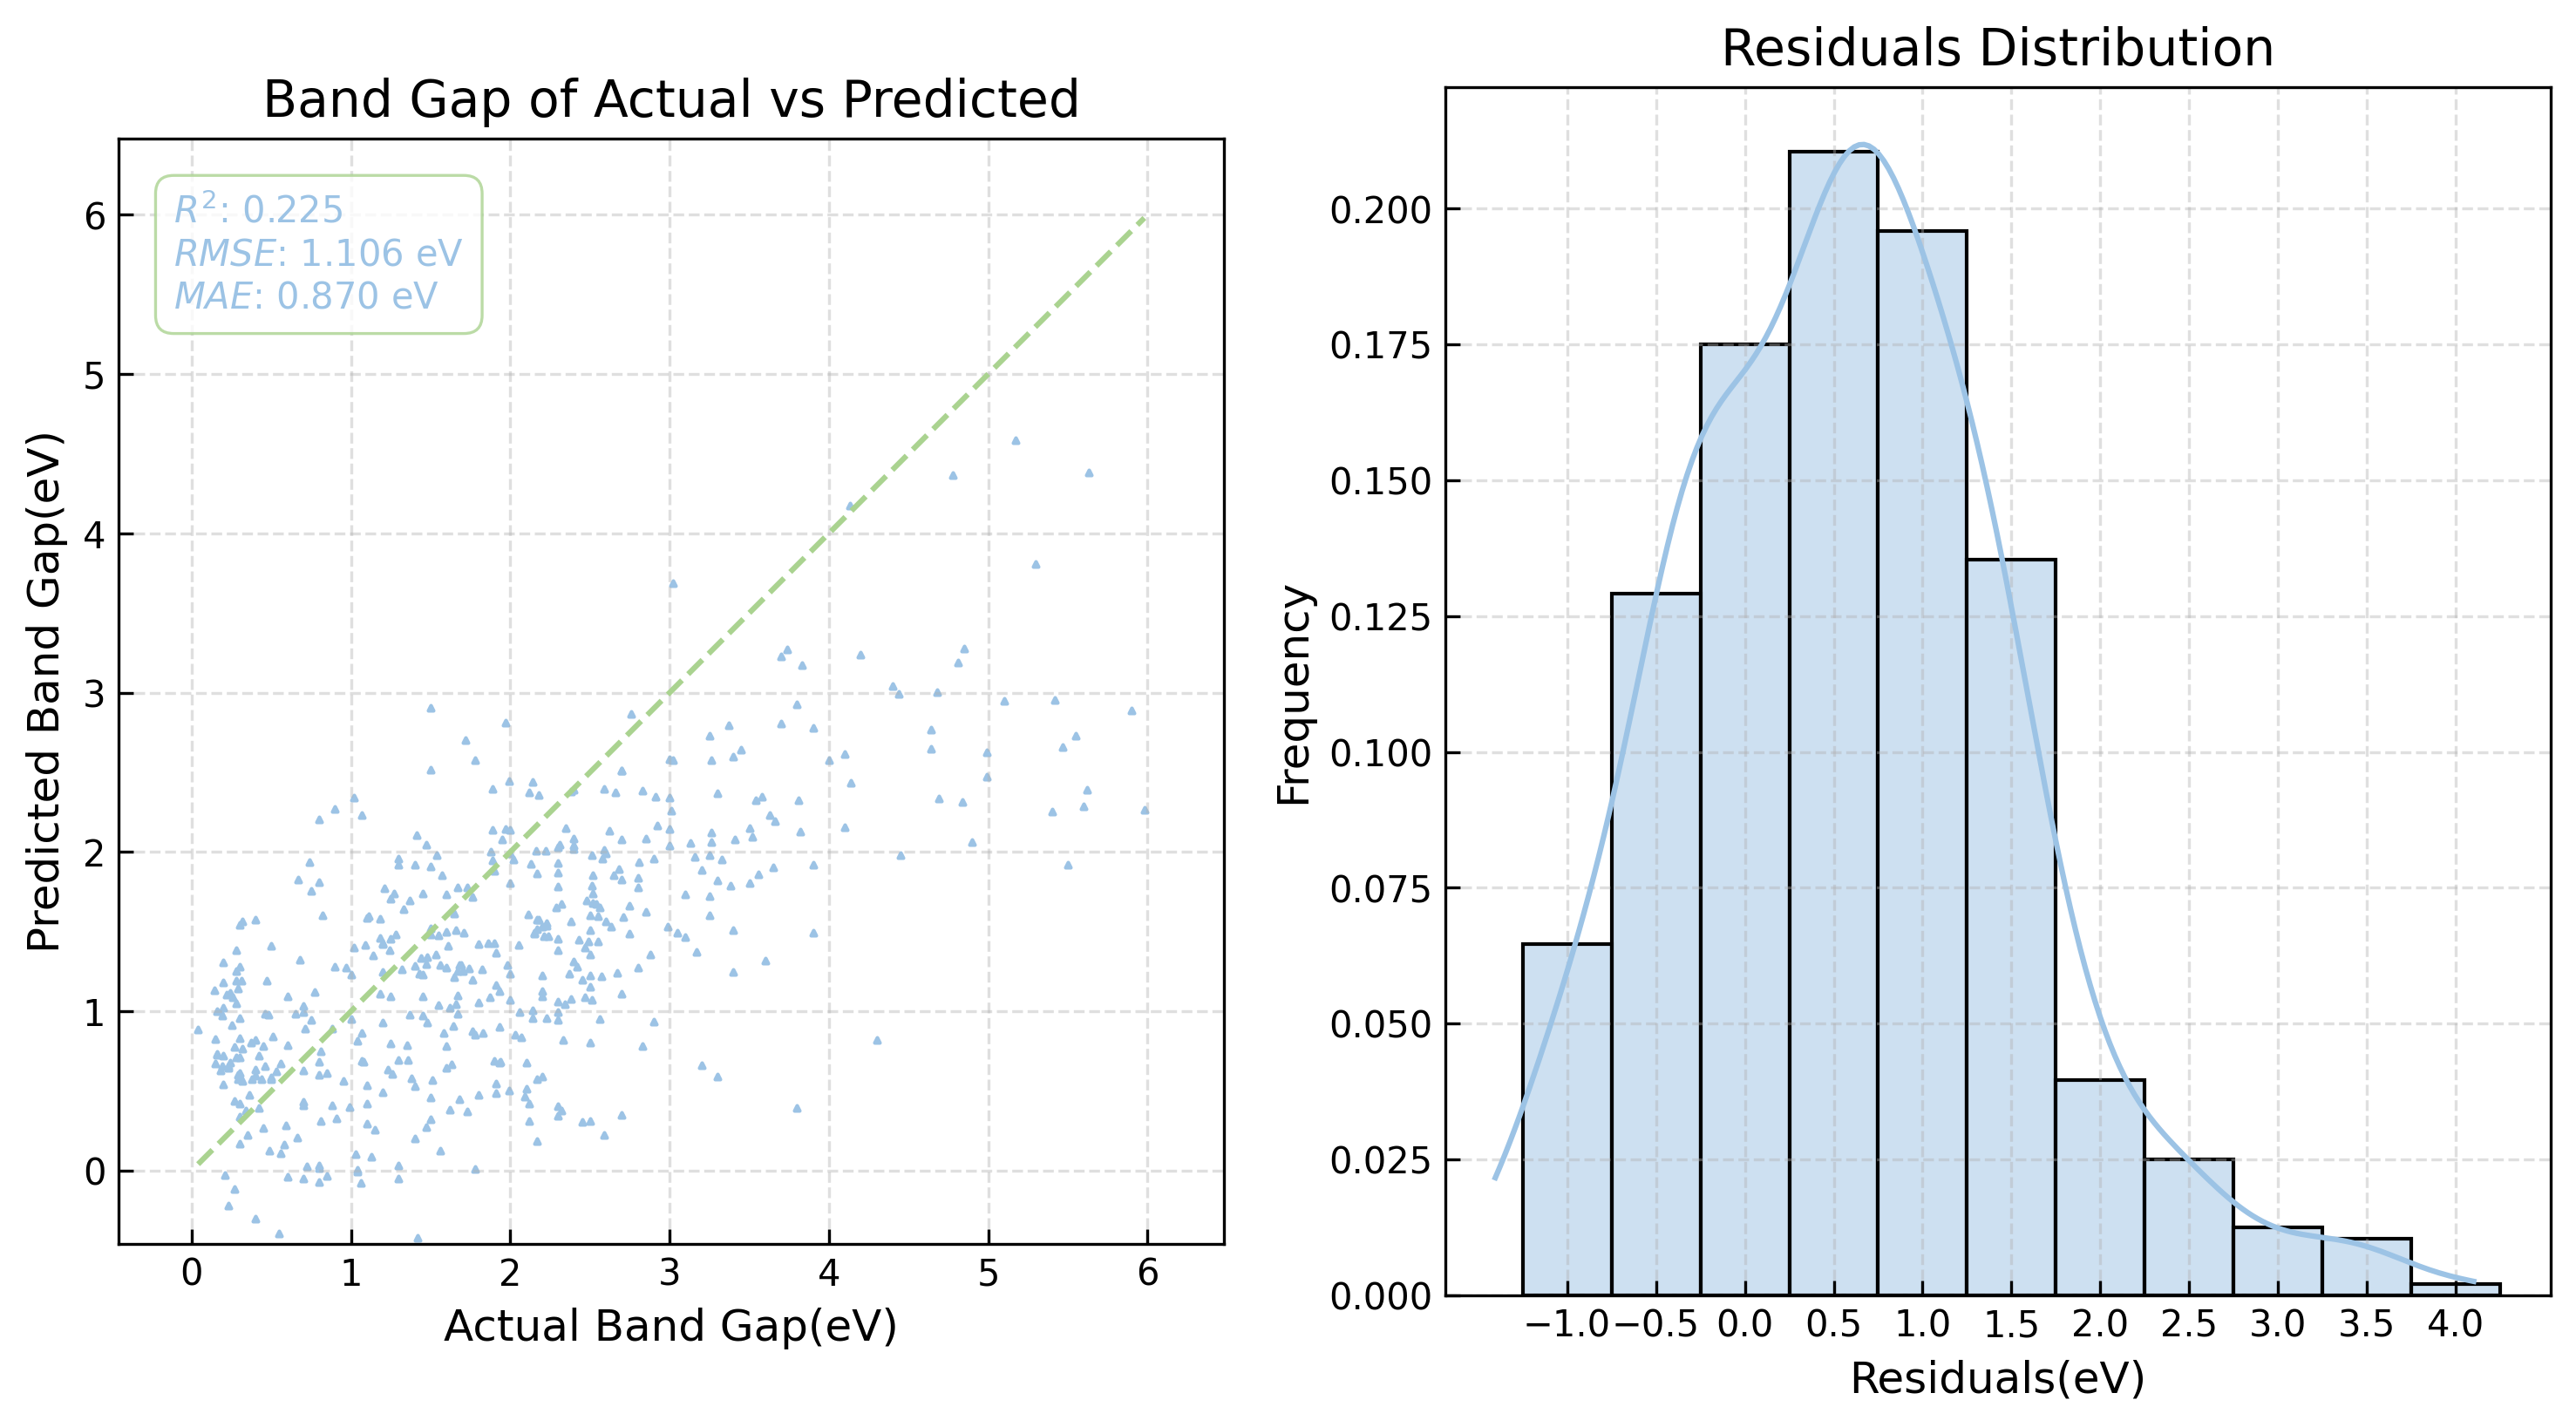


Model Evaluation Results:
Test set: R²: 0.2249 RMSE: 1.1064 MAE: 0.8698


In [8]:
# 
# Train the model with the best hyperparameters on the entire training set
lasso_best = Ridge(alpha=1.0, random_state=RANDOM_SEED)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on DFT data:")
print("-" * 100)

dft_model = SingleModel(clone(lasso_best), random_state=RANDOM_SEED)
dft_model.train(dft_train_X, dft_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating DFT {MODEL_NAME} on DFT train set:")
metrics = dft_model.evaluate(dft_train_X, dft_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test DFT -> DFT] Evaluating DFT {MODEL_NAME} on DFT test set:")

metrics = dft_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test DFT -> EXP] Evaluating DFT {MODEL_NAME} on EXP test set:")
metrics = dft_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [9]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,Ridge,Train,dft,dft,0.418538,1.125993,0.903608
1,Ridge,Test,dft,dft,0.431792,1.114208,0.894726
2,Ridge,Test,dft,exp,0.224864,1.106404,0.869790


### EXP Model

In [10]:
# using grid search to find the best hyperparameters for the dft model
print(f"['EXP {MODEL_NAME}'] HP optimazation begin...")
# create a pipeline with standard scaler and ElasticNet
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=RANDOM_SEED))
])
# define the parameter grid for ElasticNet
param_grid = {
    'ridge__alpha': np.arange(0, 1.05, 0.05)
}

# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=ridge_pipe, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=kf, 
    n_jobs=-1, 
    verbose=True,
    return_train_score=True)

# fit the model to the training data
grid_search.fit(exp_train_X, exp_train_y)

['EXP Ridge'] HP optimazation begin...
Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge(random_state=42))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=True)

In [11]:
# get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(grid_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_ridge__alpha', 
                                 'train_rmse', 'test_rmse']]

# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
results_sorted.to_csv(os.path.join(hp_path, 'exp_hp_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'ridge__alpha': np.float64(1.0)}
Best Cross-Validation RMSE: 37952.0317


,rank_test_score,param_ridge__alpha,train_rmse,test_rmse
20,1,1.00,0.672711,37952.031664
19,2,0.95,0.672696,37966.337809
18,3,0.90,0.672680,37980.600436
17,4,0.85,0.672666,37994.811760
16,5,0.80,0.672652,38008.963502


### Overfitting check

####################################################################################################
[EXP - Ridge] Training Ridge on EXP data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
Model training completed!
[Train_error] Evaluating EXP Ridge on EXP train set:


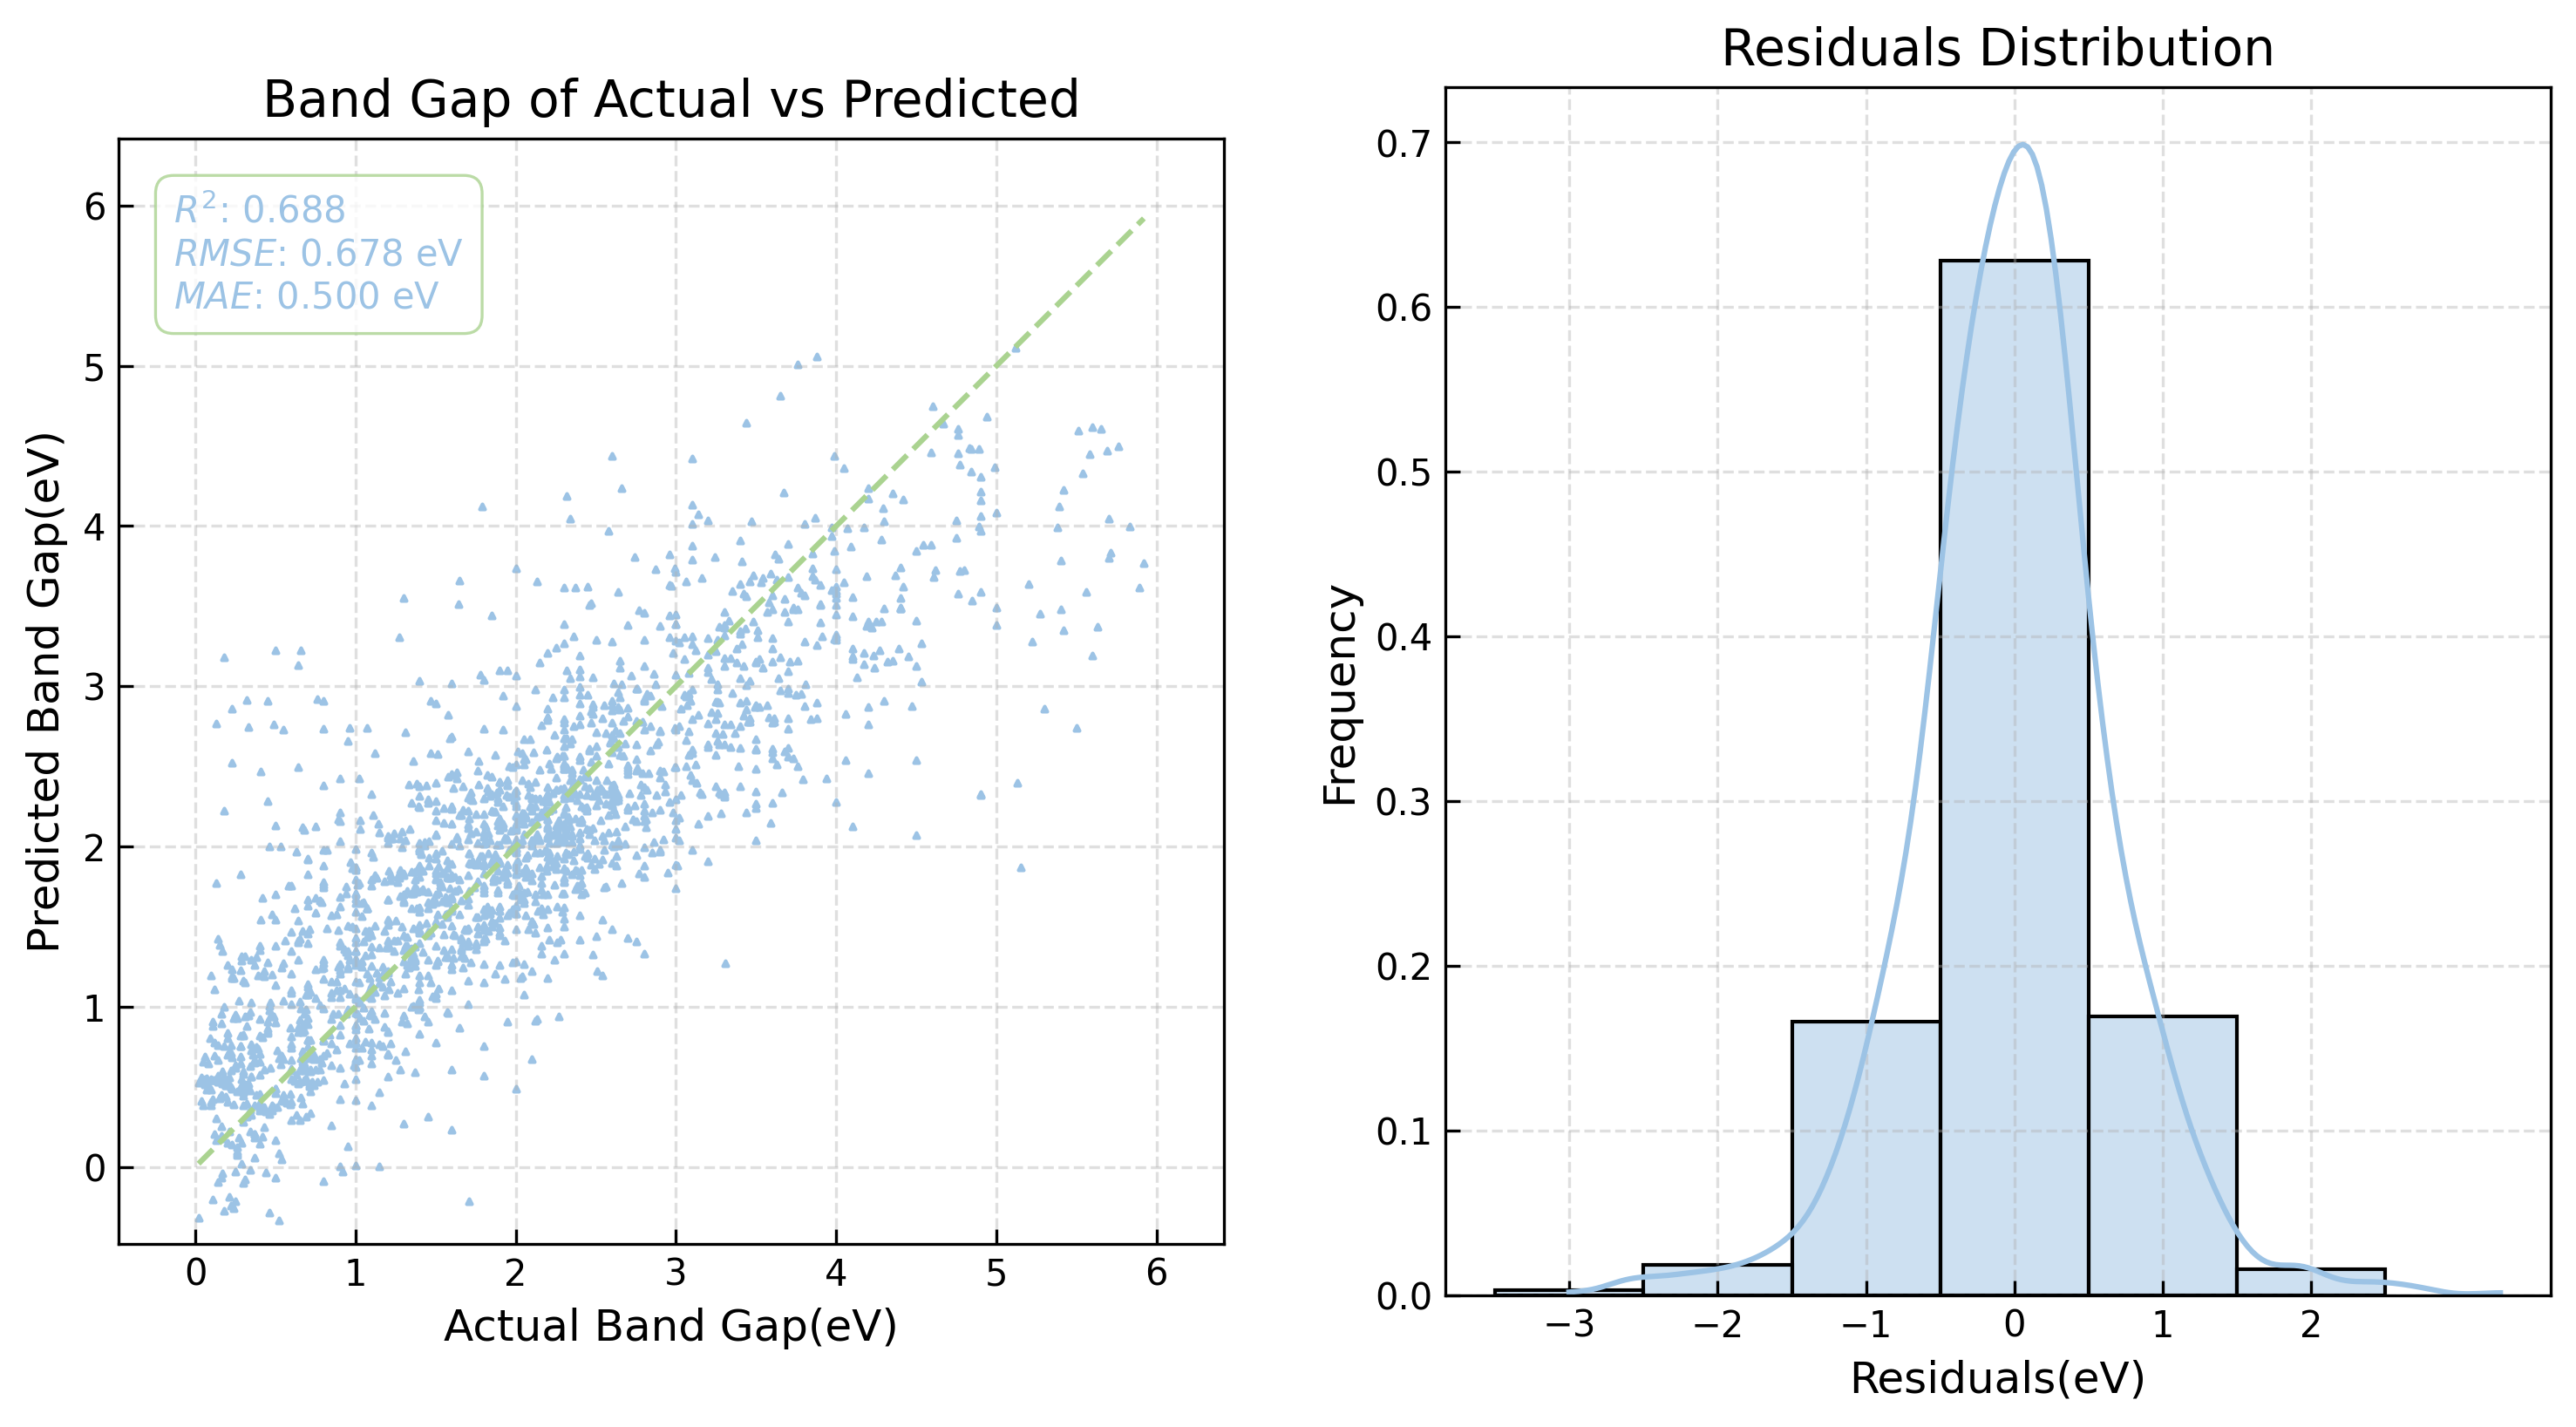


Model Evaluation Results:
Test set: R²: 0.6877 RMSE: 0.6781 MAE: 0.5000
[Test EXP -> EXP] Evaluating EXP Ridge on EXP test set:


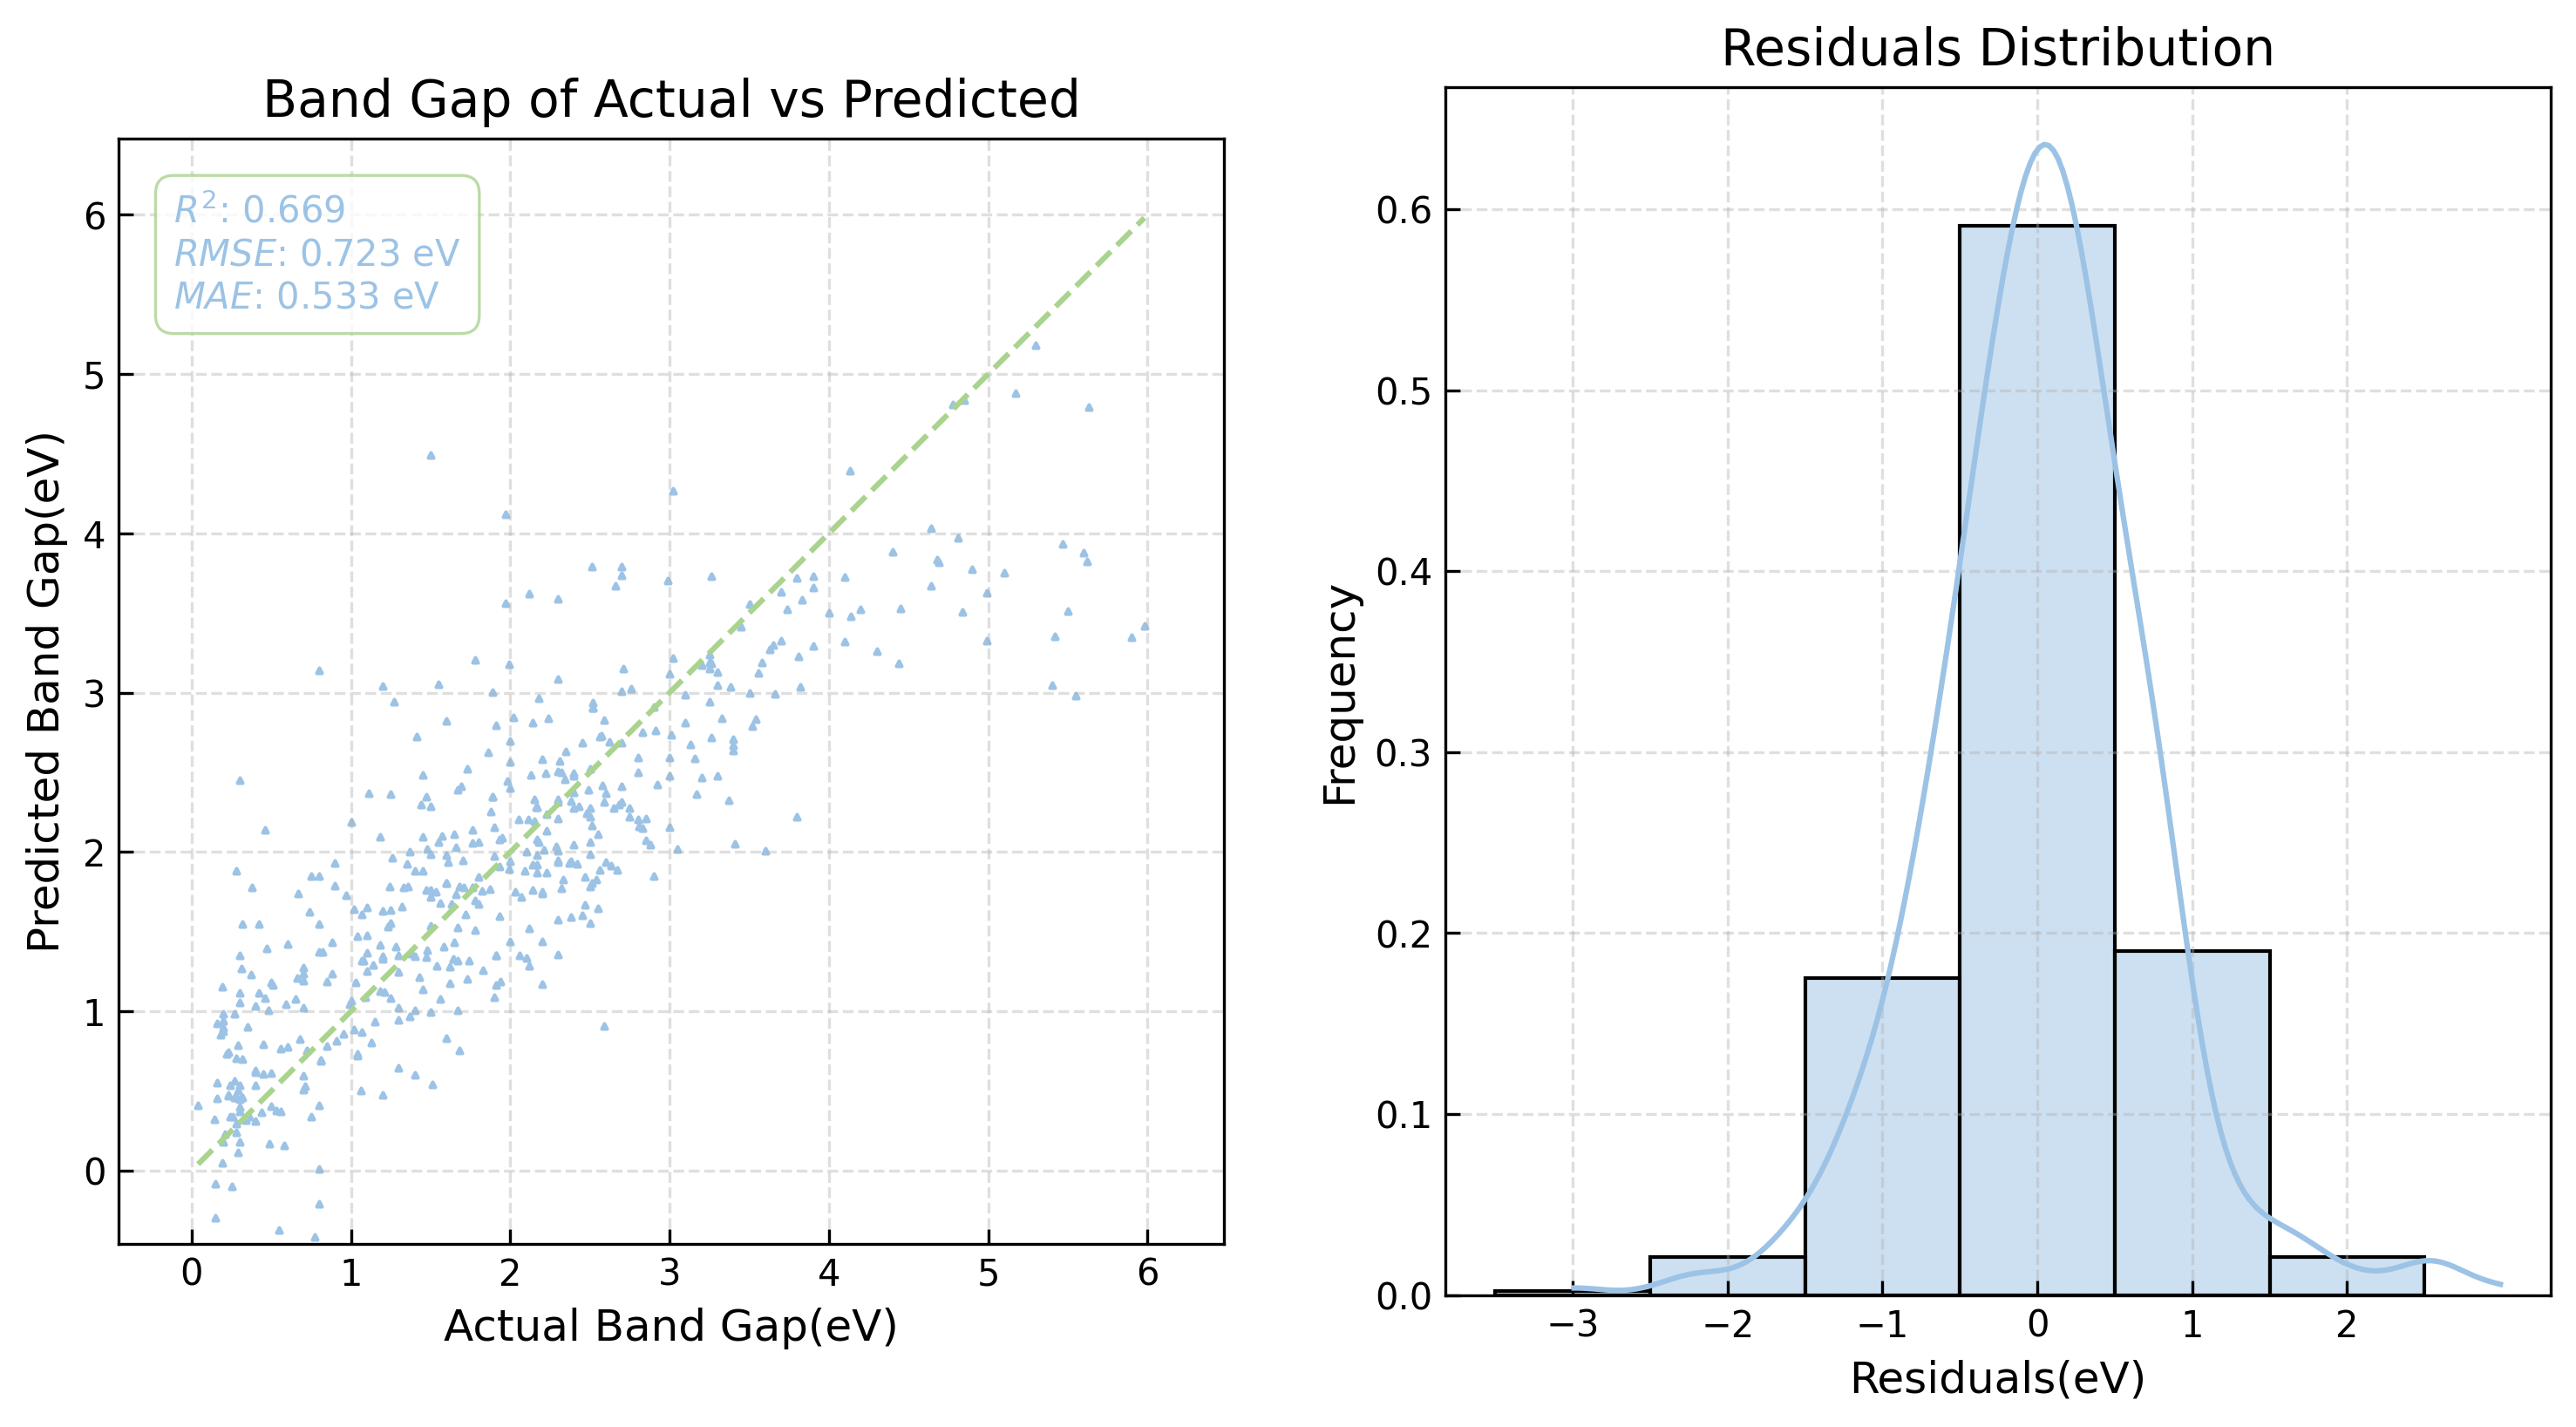


Model Evaluation Results:
Test set: R²: 0.6686 RMSE: 0.7234 MAE: 0.5330
[Test EXP -> DFT] Evaluating EXP Ridge on DFT test set:


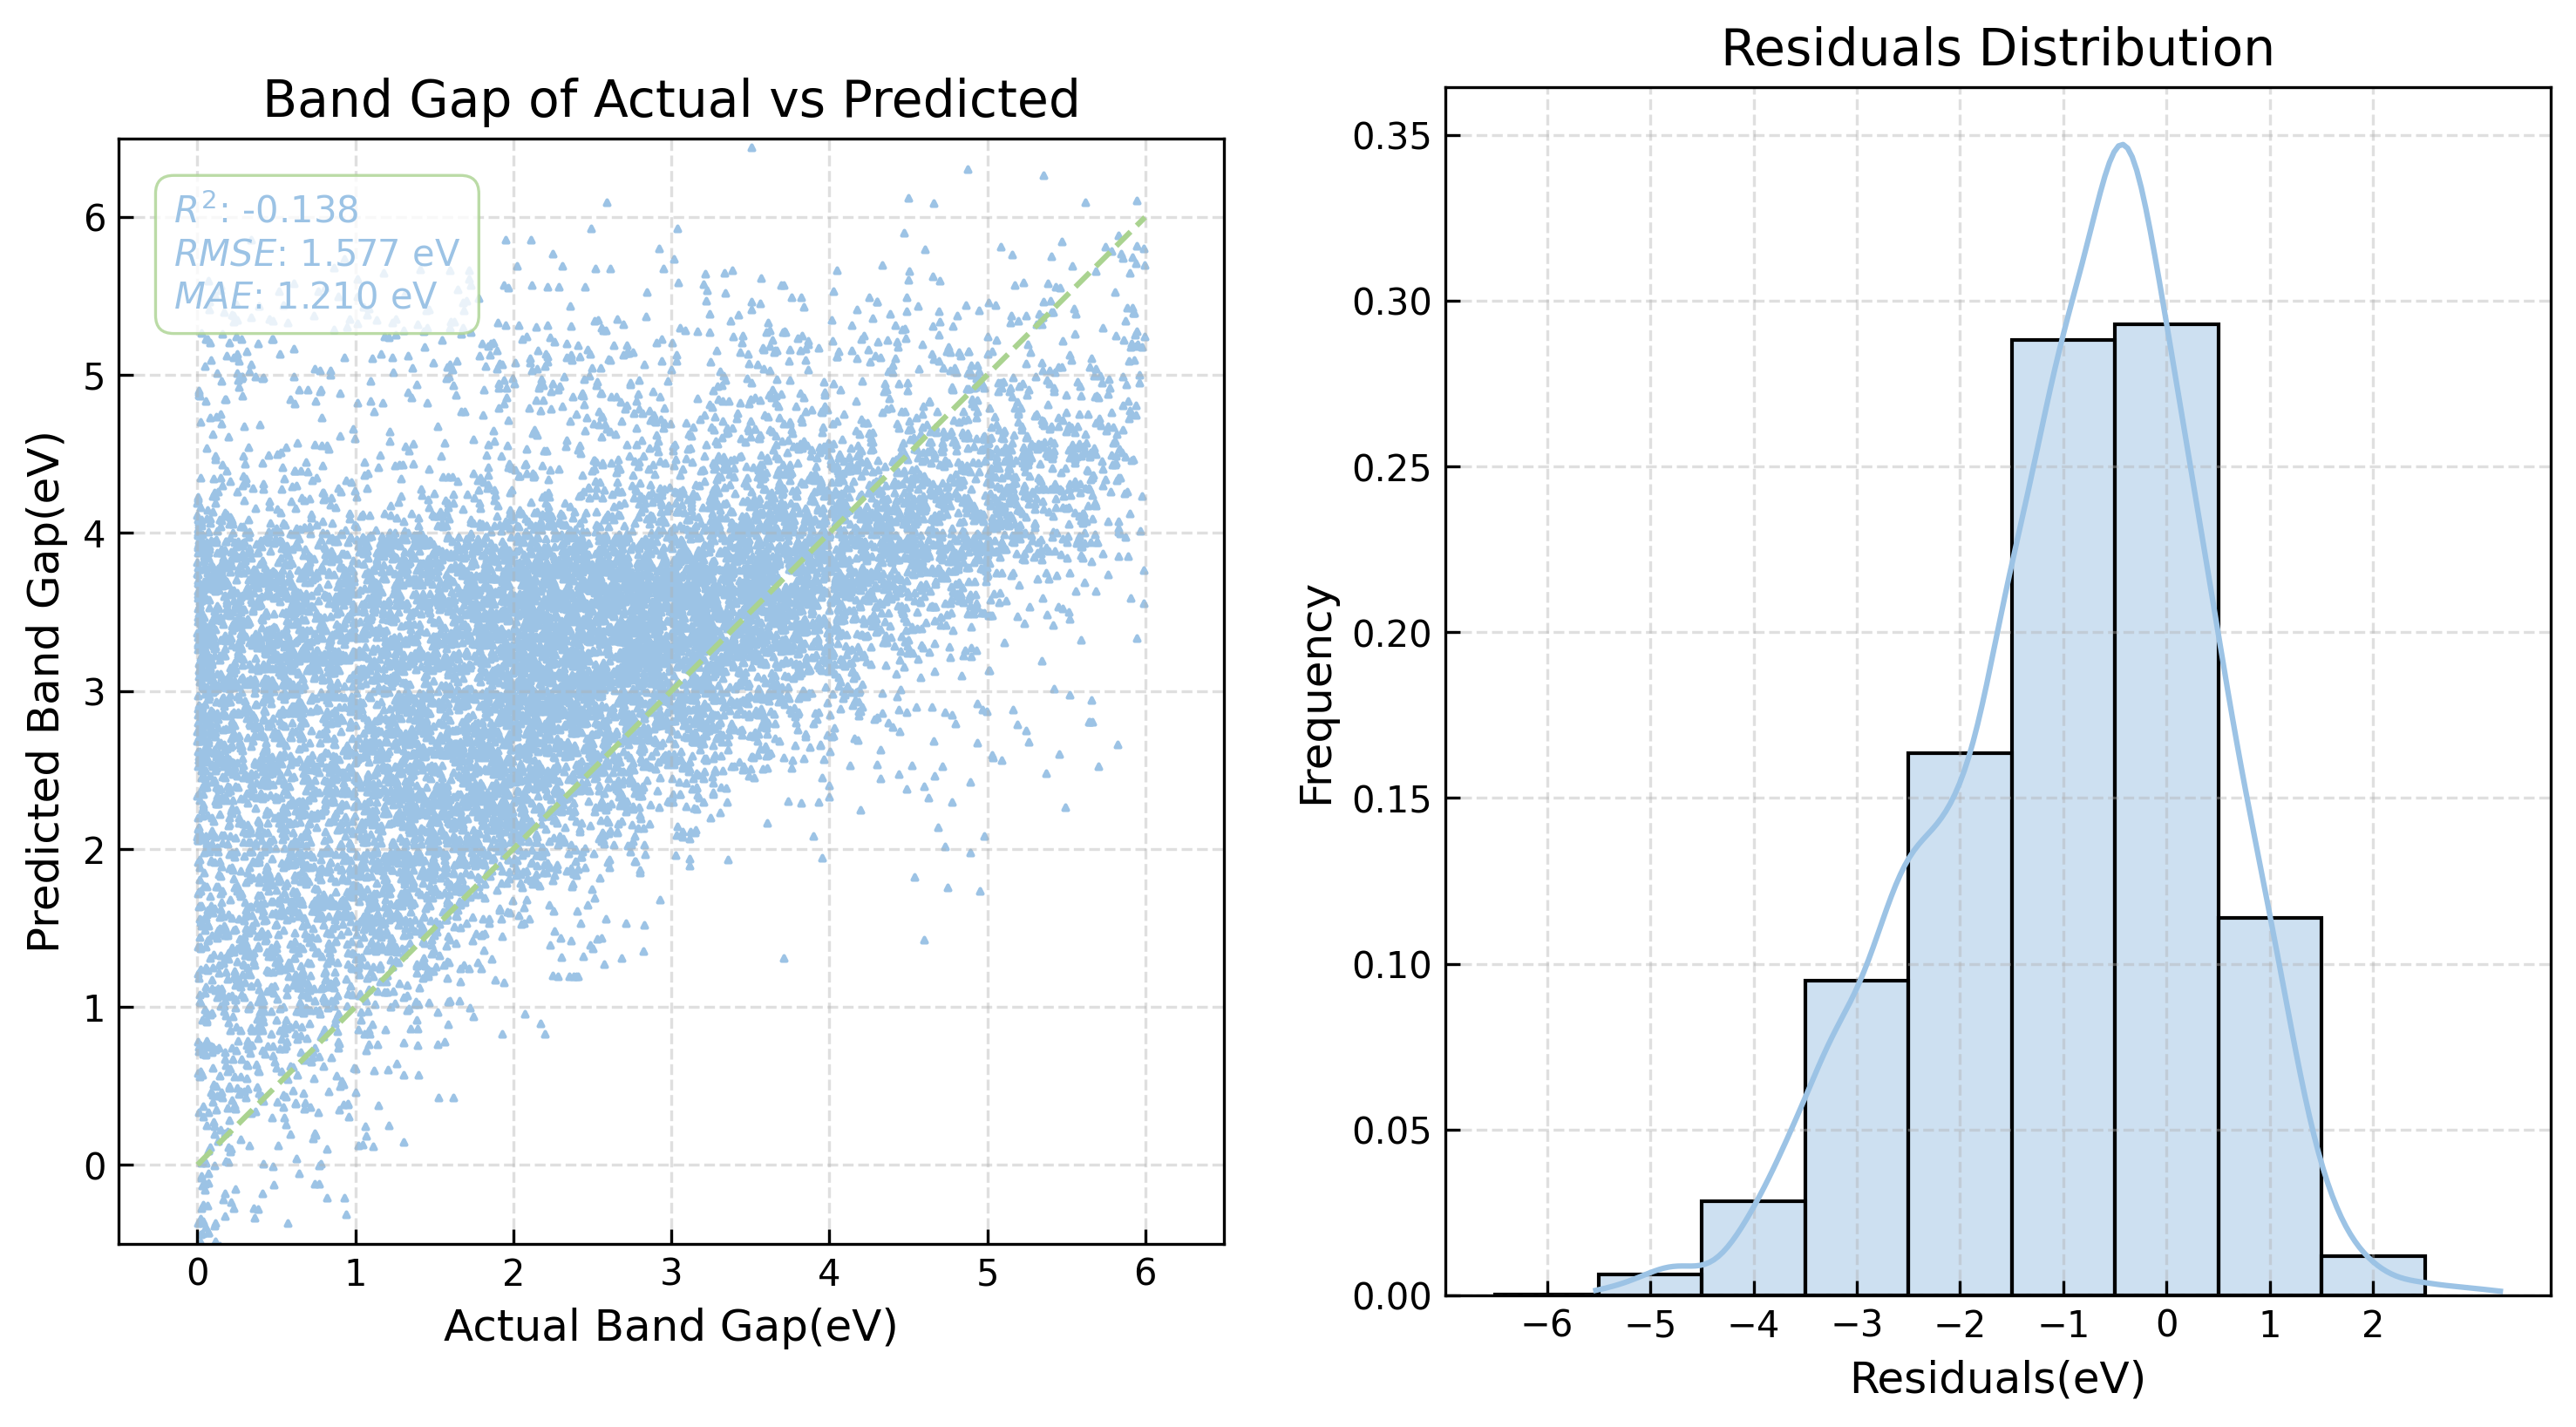


Model Evaluation Results:
Test set: R²: -0.1378 RMSE: 1.5767 MAE: 1.2100


In [12]:
# 
# Train the model with the best hyperparameters on the entire training set
ridge_best = Ridge(alpha=1.0, random_state=RANDOM_SEED)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[EXP - {MODEL_NAME}] Training {MODEL_NAME} on EXP data:")
print("-" * 100)

exp_model = SingleModel(clone(ridge_best), random_state=RANDOM_SEED)
exp_model.train(exp_train_X, exp_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating EXP {MODEL_NAME} on EXP train set:")
metrics = exp_model.evaluate(exp_train_X, exp_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test EXP -> EXP] Evaluating EXP {MODEL_NAME} on EXP test set:")

metrics = exp_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test EXP -> DFT] Evaluating EXP {MODEL_NAME} on DFT test set:")
metrics = exp_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [13]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,Ridge,Train,exp,exp,0.687697,0.678064,0.499976
1,Ridge,Test,exp,exp,0.668590,0.723448,0.533021
2,Ridge,Test,exp,dft,-0.137808,1.576693,1.210002
